In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import os
from platform import python_version
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

print(f"Tensorflow Version: {tf.__version__}")
import keras
print(f"Keras Version: {keras.__version__}")

Tensorflow Version: 2.16.1
Keras Version: 3.3.3


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth and limit memory usage
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])  # Memory limit in MB
    except RuntimeError as e:
        print(e)

# Now you can create your session or model
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto())



seed = random.randint(0, 1000)
# seed=212
# Set random seeds
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"SEED: {seed}")

SEED: 948


In [3]:
epochs = 150
batch_size = 32
testsplit = .2
img_size= 256
learning_rate = 0.0001

targetx = img_size
targety = img_size

data_dir = "/kaggle/input/riceleafsv3/RiceLeafsv3/train/"
data_dir1 = "/kaggle/input/riceleafsv3/RiceLeafsv3/validation/"

In [4]:
def custom_preprocessing(image):
    return image / 255.0

train_datagen = ImageDataGenerator(
        preprocessing_function=custom_preprocessing,
        validation_split=testsplit
)

test_datagen = ImageDataGenerator(
        preprocessing_function=custom_preprocessing
)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
       
)
val_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation",
)

test_generator = test_datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed
)

Found 1736 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Found 543 images belonging to 6 classes.


In [5]:
train_generator.class_indices

{'bacterial_leaf_blight': 0,
 'brown_spot': 1,
 'healthy': 2,
 'leaf_blast': 3,
 'leaf_scald': 4,
 'narrow_brown_spot': 5}

In [6]:
target_names=list(train_generator.class_indices.keys())
classes = len(target_names)
target_names

['bacterial_leaf_blight',
 'brown_spot',
 'healthy',
 'leaf_blast',
 'leaf_scald',
 'narrow_brown_spot']

/kaggle/input/riceleafsv3/RiceLeafsv3/train/healthy/healthy (39).jpg


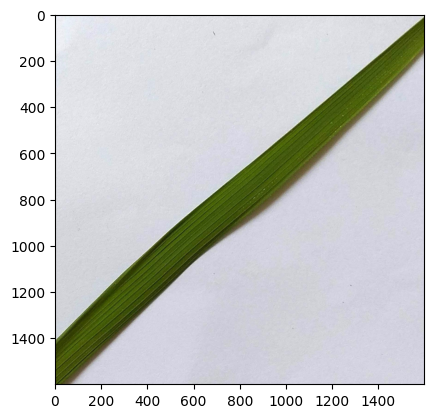

In [7]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [8]:
checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False)


earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=25,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

In [9]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

In [10]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(512, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(256, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(learning_rate=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()
# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.trainable)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 3,087,558 (11.78 MB)

 Trainable params: 3,049,094 (11.63 MB)

 Non-trainable params: 38,464 (150.25 KB)

In [11]:
%%time

model_history = model.fit(train_generator, 
                                validation_data=val_generator, 
                                epochs=epochs,
                                callbacks=[reducelr, earlystop,checkpoint])

Epoch 1/150


I0000 00:00:1725556876.671684     113 service.cc:145] XLA service 0x783944006bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725556876.671740     113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725556876.671747     113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/55 ━━━━━━━━━━━━━━━━━━━━ 51:32 57s/step - accuracy: 0.1250 - loss: 3.7927

I0000 00:00:1725556904.910609     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.2738 - loss: 5.7015
Epoch 1: val_accuracy improved from -inf to 0.23666, saving model to best_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.2755 - loss: 5.6997 - val_accuracy: 0.2367 - val_loss: 4.5264 - learning_rate: 1.0000e-04
Epoch 2/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5762 - loss: 5.1767
Epoch 2: val_accuracy improved from 0.23666 to 0.28538, saving model to best_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 396ms/step - accuracy: 0.5767 - loss: 5.1745 - val_accuracy: 0.2854 - val_loss: 4.7353 - learning_rate: 1.0000e-04
Epoch 3/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.6906 - loss: 4.6641
Epoch 3: val_accuracy improved from 0.28538 to 0.29930, saving model to best_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.6908 - loss: 4.6634 - val_accuracy: 0.2993 - val_loss: 5.6094 - learning_rate: 1.0000e-04
Epoch 4/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/ste

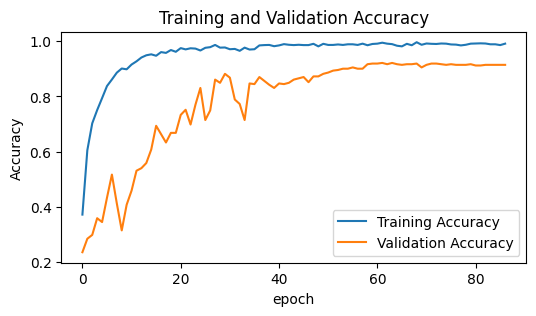

In [12]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

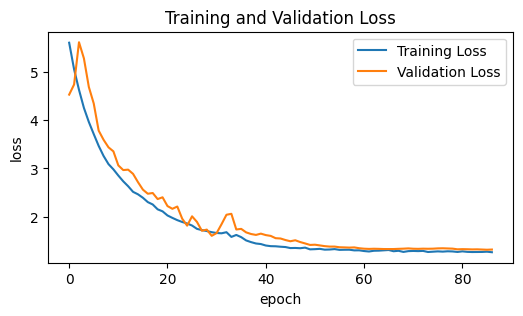

In [13]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [14]:
predictions = model.predict(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 848ms/step
Classification Report
                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      0.97      0.98        88
           brown_spot       0.94      0.87      0.91        93
              healthy       0.91      0.98      0.94        93
           leaf_blast       0.91      0.90      0.91        91
           leaf_scald       1.00      1.00      1.00        90
    narrow_brown_spot       0.96      1.00      0.98        88

             accuracy                           0.95       543
            macro avg       0.95      0.95      0.95       543
         weighted avg       0.95      0.95      0.95       543



In [15]:
#confusion matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true=test_generator.classes


from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)
cm

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 326ms/step


array([[85,  0,  0,  0,  0,  3],
       [ 0, 81,  5,  7,  0,  0],
       [ 0,  1, 91,  1,  0,  0],
       [ 0,  4,  4, 82,  0,  1],
       [ 0,  0,  0,  0, 90,  0],
       [ 0,  0,  0,  0,  0, 88]])

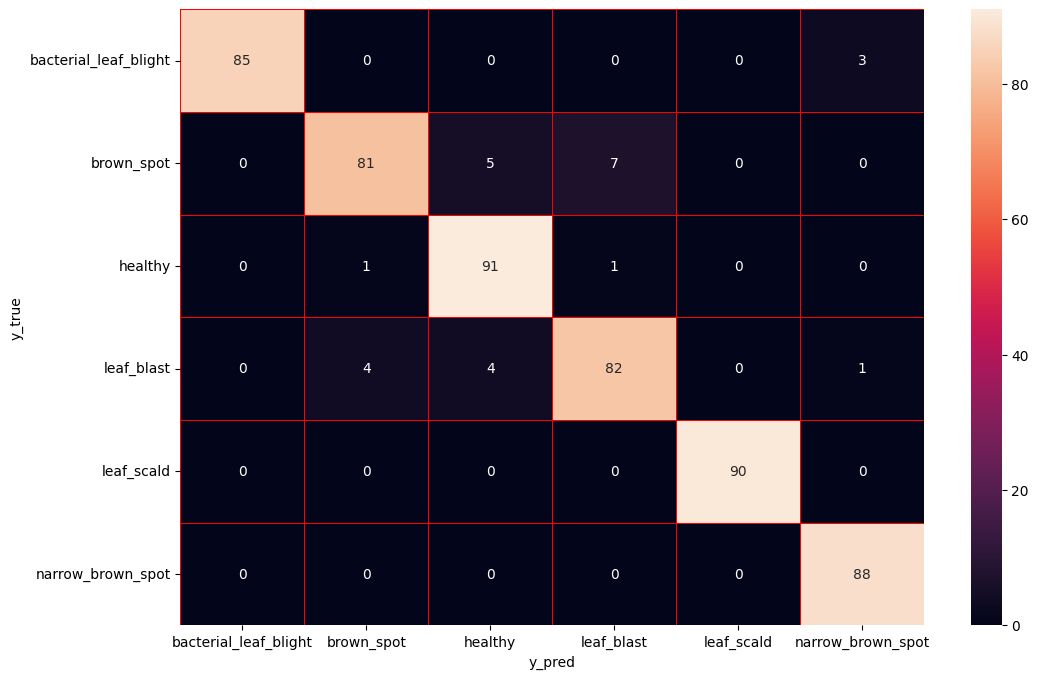

In [16]:
f, ax=plt.subplots(figsize=(12,8))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax,xticklabels=target_names, yticklabels=target_names,)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig('confusion_matrix.png', transparent=False, dpi=500)
plt.show()

In [17]:
model.evaluate(test_generator , verbose = 1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9400 - loss: 1.2496


[1.2127147912979126, 0.9521178603172302]